# Import thu vien

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=911e184ea31ff0c12dee802a93e32e1cf6ba150dc9a7838388df99e7c6dd5939
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=12f41dd2250ea14d6046b76b15e0bf171ed574d74e13ecb8df044978429c6b03
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import timm
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import SegformerForSemanticSegmentation

# Test

[0 1 2 3 4]


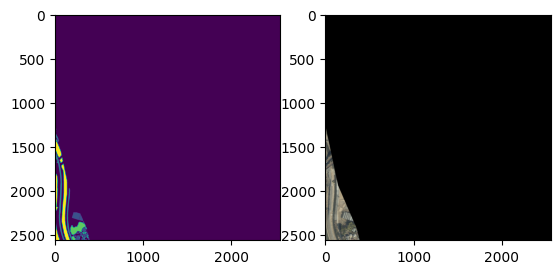

In [ ]:
mask_path = "/content/drive/MyDrive/NAVER/Mask2_resample/Mask_Row(250)_Col(322)_resample.tif"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
img_path = "/content/drive/MyDrive/NAVER/TrueOrtho_resample/Ortho_Row(250)_Col(322)_resample.tif"
img= cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(img)
print(np.unique(mask))

# Tao CustomDataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, root_dir, txt_file, transform = None):
    super().__init__()
    self.root_dir = root_dir
    self.txt_file= txt_file
    self.transform = transform
    self.img_path_list = []
    with open(self.txt_file) as file_in:
      for line in file_in:
        self.img_path_list.append(line)

  def __len__(self):
    return len(self.img_path_list)

  def __getitem__(self, idx):
    filename = self.img_path_list[idx]
    base, ext = os.path.splitext(filename)
    resample_filename1 = f"{base}{ext}"
    base2 = base.replace('Ortho', 'Mask_Building')
    resample_filename2 = f"{base2}{ext}"

    image_path = os.path.join(self.root_dir,"TrueOrtho_resample", resample_filename1.strip())
    mask_path = os.path.join(self.root_dir,"Mask2_Building_resample", resample_filename2.strip())
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if self.transform is not None:
      transformed = self.transform(image = image, mask = mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']
    return transformed_image, transformed_mask

# Augmentation anh

In [ ]:
train_transformed = A.Compose([
    A.Resize(width=720, height=720),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, border_mode=cv2.BORDER_REFLECT),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
    A.GaussNoise(),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transformed = A.Compose([
    A.Resize(width=1024, height=1024),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

val_transformed = A.Compose([
    A.Resize(width=720, height=720),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])


In [ ]:
train_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/train.txt", train_transformed)
test_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/test.txt", test_transformed)
val_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/val.txt", val_transformed)
train_dataset.__getitem__(98)


(tensor([[[ 0.3823,  0.1083, -0.1143,  ..., -0.9020, -0.7993, -0.6965],
          [-0.0458, -0.0458, -0.5424,  ..., -0.5082, -0.8164, -0.8335],
          [-0.5082, -0.5424, -0.9020,  ..., -0.1999, -0.4397, -0.7308],
          ...,
          [-1.4158, -1.3644, -1.4329,  ..., -1.3302, -1.2617, -1.5699],
          [-1.5870, -1.4672, -1.4843,  ..., -1.3644, -1.1932, -1.4158],
          [-1.5699, -1.3473, -1.4158,  ..., -1.2617, -1.1932, -1.3130]],
 
         [[ 0.5378,  0.2402,  0.3277,  ..., -0.6352, -0.5126, -0.4951],
          [ 0.1001,  0.0301, -0.3025,  ..., -0.3725, -0.5301, -0.7227],
          [-0.2150, -0.4776, -0.3725,  ..., -0.0224, -0.3025, -0.5301],
          ...,
          [-0.8102, -0.8452, -0.7577,  ..., -0.6176, -0.7577, -0.6527],
          [-0.8102, -0.8277, -0.8627,  ..., -0.7402, -0.5826, -0.8102],
          [-0.6877, -0.8627, -0.9153,  ..., -0.7402, -0.8978, -0.8627]],
 
         [[ 0.5311,  0.3219,  0.4091,  ..., -0.4624, -0.3927, -0.5495],
          [ 0.1128,  0.2348,

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


# U Net model

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Tinh Accuracy

In [ ]:
def accuracy_function(preds, targets):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    acc_class = []
    for i in range(2):  # Assuming 2 classes
        indices = targets_flat == i
        total = indices.sum().item()
        if total > 0:
            correct = (preds_flat[indices] == targets_flat[indices]).sum().item()
            acc_class.append(correct / total)
    return sum(acc_class) / len(acc_class) if acc_class else 0

def calculate_recall(intersection, target):
    # Recall = TP / (TP + FN)
    # In this case, TP is the intersection and FN is target - intersection
    recall = intersection / (target - intersection + 1e-10)
    return recall

def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [ ]:
from transformers import SegformerForSemanticSegmentation
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 2
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)
#model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640").to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_eps = 300
#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
recall_meter = AverageMeter()
target_meter = AverageMeter()

val_loss_meter = AverageMeter()
val_intersection_meter = AverageMeter()
val_union_meter = AverageMeter()
val_target_meter = AverageMeter()

num_workers = 2


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

# Train

In [ ]:
from torch.cuda.amp import GradScaler, autocast
import copy

# Initialize the gradient scaler
scaler = GradScaler()

# Set the number of accumulation steps
accumulation_steps = 16 # Adjust this value according to your memory limit

best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

train_losses =[]
val_losses = []
accuracy_list =[]
iou_list = []
dice_list= []

for ep in range(1, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    recall_meter.reset()
    model.train()

    optimizer.zero_grad()  # Reset gradients tensors

    #training loop
    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()

        # Runs the forward pass with autocasting.
        with autocast():
            y_hat = model(x).logits #(B, C, H, W)
            y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
            loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
            loss = loss / accumulation_steps  # Normalize our loss (if averaged)

        scaler.scale(loss).backward()

        # Backward passes without optimization every few batches
        if (batch_id + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item() * accumulation_steps)  # We have to scale our loss back
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 2)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector 2D
        accuracy = intersection_meter.sum / (target_meter.sum + 1e-10) #vector 2D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10)

        mIoU = torch.mean(iou_class) #mean vector 2D
        mAcc = torch.mean(accuracy) #mean vector 2D
        mDice = torch.mean(dice_class)

    accuracy_list.append(mAcc.item())
    iou_list.append(mIoU.item())
    dice_list.append(mDice.item())
    train_losses.append(train_loss_meter.avg)
    #Validation Loop
    val_loss_meter.reset()
    val_intersection_meter.reset()
    val_union_meter.reset()
    val_target_meter.reset()
    model.eval()

    with torch.no_grad():
        for x,y in valloader:
            n = x.shape[0]
            x = x.to(device).float()
            y = y.to(device).long()
            y_hat = model(x).logits
            y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
            loss = criterion(y_hat, y)

            #save metrics
            val_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 2)
            val_intersection_meter.update(intersection)
            val_union_meter.update(union)
            val_target_meter.update(target)

        #compute iou, dice
        iou_class = val_intersection_meter.sum / (val_union_meter.sum + 1e-10)
        accuracy = val_intersection_meter.sum / (val_target_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10)

        mIoU = torch.mean(iou_class)
        mAcc = torch.mean(accuracy)
        mDice = torch.mean(dice_class)

    val_loss = val_loss_meter.avg
    val_losses.append(val_loss_meter.avg)
    print("EP {}, val loss = {:.5f}".format(ep, val_loss_meter.avg))
    print("EP {}, train loss = {:.5f} IoU = {:.5f}, Accuracy = {:.5f}, Dice= {:.5f}".format(ep, train_loss_meter.avg, mIoU, mAcc, mDice))

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      best_epoch_preds = y_hat.argmax(dim=1).view(-1).cpu().numpy()
      best_epoch_targets = y.view(-1).cpu().numpy()  # Store the best epoch targets

    model.load_state_dict(best_model_wts)


100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


EP 1, val loss = 2.52546
EP 1, train loss = 3.03121 IoU = 0.40172, Accuracy = 0.50706, Dice= 0.45491


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 2, val loss = 1.50452
EP 2, train loss = 1.43932 IoU = 0.39649, Accuracy = 0.42697, Dice= 0.54486


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 3, val loss = 0.79999
EP 3, train loss = 0.94578 IoU = 0.50369, Accuracy = 0.57383, Dice= 0.57722


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 4, val loss = 0.60168
EP 4, train loss = 0.74942 IoU = 0.53729, Accuracy = 0.62920, Dice= 0.59244


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 5, val loss = 0.41483
EP 5, train loss = 0.63697 IoU = 0.55557, Accuracy = 0.64622, Dice= 0.60364


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 6, val loss = 0.37154
EP 6, train loss = 0.57802 IoU = 0.57405, Accuracy = 0.68125, Dice= 0.62791


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 7, val loss = 0.32773
EP 7, train loss = 0.54169 IoU = 0.61858, Accuracy = 0.77024, Dice= 0.65461


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


EP 8, val loss = 0.23290
EP 8, train loss = 0.47000 IoU = 0.60161, Accuracy = 0.66338, Dice= 0.66610


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 9, val loss = 0.24135
EP 9, train loss = 0.45335 IoU = 0.63508, Accuracy = 0.73415, Dice= 0.66752


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 10, val loss = 0.27496
EP 10, train loss = 0.45319 IoU = 0.64217, Accuracy = 0.77806, Dice= 0.66727


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 11, val loss = 0.24886
EP 11, train loss = 0.40798 IoU = 0.64680, Accuracy = 0.78536, Dice= 0.67852


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 12, val loss = 0.23251
EP 12, train loss = 0.45856 IoU = 0.63755, Accuracy = 0.74614, Dice= 0.66038


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 13, val loss = 0.21588
EP 13, train loss = 0.42888 IoU = 0.64753, Accuracy = 0.75579, Dice= 0.68240


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 14, val loss = 0.18441
EP 14, train loss = 0.40915 IoU = 0.59751, Accuracy = 0.64245, Dice= 0.68954


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 15, val loss = 0.18438
EP 15, train loss = 0.36204 IoU = 0.64803, Accuracy = 0.72924, Dice= 0.69446


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 16, val loss = 0.16873
EP 16, train loss = 0.37368 IoU = 0.65908, Accuracy = 0.75004, Dice= 0.69419


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 17, val loss = 0.17502
EP 17, train loss = 0.33236 IoU = 0.65779, Accuracy = 0.74207, Dice= 0.70870


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 18, val loss = 0.15828
EP 18, train loss = 0.34563 IoU = 0.65475, Accuracy = 0.73360, Dice= 0.70259


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 19, val loss = 0.16622
EP 19, train loss = 0.36719 IoU = 0.65077, Accuracy = 0.72380, Dice= 0.69369


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 20, val loss = 0.17895
EP 20, train loss = 0.34440 IoU = 0.65265, Accuracy = 0.72989, Dice= 0.70813


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 21, val loss = 0.16577
EP 21, train loss = 0.35045 IoU = 0.62632, Accuracy = 0.67866, Dice= 0.69519


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 22, val loss = 0.16276
EP 22, train loss = 0.33083 IoU = 0.61934, Accuracy = 0.66764, Dice= 0.70023


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 23, val loss = 0.15812
EP 23, train loss = 0.38911 IoU = 0.63441, Accuracy = 0.69173, Dice= 0.68731


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 24, val loss = 0.16608
EP 24, train loss = 0.35669 IoU = 0.62245, Accuracy = 0.67057, Dice= 0.70817


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 25, val loss = 0.17227
EP 25, train loss = 0.32116 IoU = 0.66445, Accuracy = 0.75547, Dice= 0.70760


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 26, val loss = 0.17338
EP 26, train loss = 0.33234 IoU = 0.66294, Accuracy = 0.75650, Dice= 0.70334


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 27, val loss = 0.16878
EP 27, train loss = 0.34688 IoU = 0.67364, Accuracy = 0.78577, Dice= 0.70594


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 28, val loss = 0.16365
EP 28, train loss = 0.34762 IoU = 0.66419, Accuracy = 0.75620, Dice= 0.70248


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 29, val loss = 0.18836
EP 29, train loss = 0.32210 IoU = 0.67548, Accuracy = 0.79645, Dice= 0.71236


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 30, val loss = 0.15032
EP 30, train loss = 0.35312 IoU = 0.65774, Accuracy = 0.73469, Dice= 0.70021


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 31, val loss = 0.17077
EP 31, train loss = 0.32642 IoU = 0.66287, Accuracy = 0.74768, Dice= 0.71282


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


EP 32, val loss = 0.17424
EP 32, train loss = 0.34266 IoU = 0.66734, Accuracy = 0.75715, Dice= 0.70889


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 33, val loss = 0.15842
EP 33, train loss = 0.32782 IoU = 0.61834, Accuracy = 0.66364, Dice= 0.70357


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 34, val loss = 0.16655
EP 34, train loss = 0.35083 IoU = 0.60212, Accuracy = 0.64330, Dice= 0.70226


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 35, val loss = 0.16057
EP 35, train loss = 0.33870 IoU = 0.61768, Accuracy = 0.66303, Dice= 0.70377


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 36, val loss = 0.16638
EP 36, train loss = 0.34219 IoU = 0.66256, Accuracy = 0.73878, Dice= 0.70513


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 37, val loss = 0.15417
EP 37, train loss = 0.36159 IoU = 0.63336, Accuracy = 0.68689, Dice= 0.70165


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 38, val loss = 0.16432
EP 38, train loss = 0.35482 IoU = 0.58014, Accuracy = 0.61610, Dice= 0.71179


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 39, val loss = 0.16897
EP 39, train loss = 0.32430 IoU = 0.63351, Accuracy = 0.68775, Dice= 0.70957


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 40, val loss = 0.16702
EP 40, train loss = 0.33788 IoU = 0.59648, Accuracy = 0.63495, Dice= 0.69739


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 41, val loss = 0.15983
EP 41, train loss = 0.34522 IoU = 0.65079, Accuracy = 0.71769, Dice= 0.70502


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 42, val loss = 0.15840
EP 42, train loss = 0.34429 IoU = 0.60776, Accuracy = 0.64949, Dice= 0.70978


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 43, val loss = 0.17551
EP 43, train loss = 0.33609 IoU = 0.66137, Accuracy = 0.74219, Dice= 0.70894


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 44, val loss = 0.17763
EP 44, train loss = 0.31336 IoU = 0.66404, Accuracy = 0.74411, Dice= 0.71921


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 45, val loss = 0.16167
EP 45, train loss = 0.31126 IoU = 0.63649, Accuracy = 0.68979, Dice= 0.71529


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 46, val loss = 0.15884
EP 46, train loss = 0.34170 IoU = 0.65623, Accuracy = 0.72991, Dice= 0.71389


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 47, val loss = 0.17093
EP 47, train loss = 0.31269 IoU = 0.66554, Accuracy = 0.75606, Dice= 0.71696


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 48, val loss = 0.14587
EP 48, train loss = 0.34278 IoU = 0.64054, Accuracy = 0.69824, Dice= 0.70661


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 49, val loss = 0.16198
EP 49, train loss = 0.33253 IoU = 0.66688, Accuracy = 0.75406, Dice= 0.69164


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 50, val loss = 0.14962
EP 50, train loss = 0.30892 IoU = 0.66747, Accuracy = 0.75040, Dice= 0.71384


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 51, val loss = 0.15990
EP 51, train loss = 0.32682 IoU = 0.67108, Accuracy = 0.75664, Dice= 0.70769


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 52, val loss = 0.17834
EP 52, train loss = 0.31051 IoU = 0.67831, Accuracy = 0.78406, Dice= 0.71012


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 53, val loss = 0.16441
EP 53, train loss = 0.31571 IoU = 0.67016, Accuracy = 0.75395, Dice= 0.71645


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 54, val loss = 0.17648
EP 54, train loss = 0.31988 IoU = 0.68325, Accuracy = 0.80520, Dice= 0.71057


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 55, val loss = 0.17256
EP 55, train loss = 0.33393 IoU = 0.68244, Accuracy = 0.81151, Dice= 0.70594


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 56, val loss = 0.18946
EP 56, train loss = 0.30334 IoU = 0.68249, Accuracy = 0.83011, Dice= 0.71663


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 57, val loss = 0.16771
EP 57, train loss = 0.33370 IoU = 0.67409, Accuracy = 0.76816, Dice= 0.69833


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 58, val loss = 0.16549
EP 58, train loss = 0.33145 IoU = 0.67220, Accuracy = 0.76184, Dice= 0.71188


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 59, val loss = 0.16732
EP 59, train loss = 0.33061 IoU = 0.67308, Accuracy = 0.78959, Dice= 0.70502


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 60, val loss = 0.16975
EP 60, train loss = 0.31624 IoU = 0.67651, Accuracy = 0.78008, Dice= 0.71374


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 61, val loss = 0.17101
EP 61, train loss = 0.30997 IoU = 0.68020, Accuracy = 0.79043, Dice= 0.71710


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 62, val loss = 0.15572
EP 62, train loss = 0.35000 IoU = 0.66965, Accuracy = 0.75715, Dice= 0.70502


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


EP 63, val loss = 0.13102
EP 63, train loss = 0.33836 IoU = 0.66496, Accuracy = 0.74095, Dice= 0.70366


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 64, val loss = 0.13715
EP 64, train loss = 0.34650 IoU = 0.65204, Accuracy = 0.71483, Dice= 0.71037


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 65, val loss = 0.15052
EP 65, train loss = 0.33135 IoU = 0.60755, Accuracy = 0.64977, Dice= 0.70799


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 66, val loss = 0.16147
EP 66, train loss = 0.30334 IoU = 0.65894, Accuracy = 0.72588, Dice= 0.71501


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 67, val loss = 0.14723
EP 67, train loss = 0.31161 IoU = 0.64586, Accuracy = 0.70369, Dice= 0.71301


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 68, val loss = 0.15778
EP 68, train loss = 0.29581 IoU = 0.67165, Accuracy = 0.75460, Dice= 0.72460


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 69, val loss = 0.16120
EP 69, train loss = 0.31883 IoU = 0.66716, Accuracy = 0.75026, Dice= 0.71188


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 70, val loss = 0.15914
EP 70, train loss = 0.31019 IoU = 0.65684, Accuracy = 0.72512, Dice= 0.72460


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


EP 71, val loss = 0.16683
EP 71, train loss = 0.31536 IoU = 0.65729, Accuracy = 0.72108, Dice= 0.71943


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 72, val loss = 0.14199
EP 72, train loss = 0.30842 IoU = 0.65467, Accuracy = 0.71842, Dice= 0.71640


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 73, val loss = 0.13990
EP 73, train loss = 0.30928 IoU = 0.64035, Accuracy = 0.69329, Dice= 0.72571


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 74, val loss = 0.15205
EP 74, train loss = 0.31322 IoU = 0.62545, Accuracy = 0.67168, Dice= 0.70752


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 75, val loss = 0.16464
EP 75, train loss = 0.30760 IoU = 0.65366, Accuracy = 0.72004, Dice= 0.71336


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 76, val loss = 0.16003
EP 76, train loss = 0.30892 IoU = 0.65920, Accuracy = 0.72951, Dice= 0.71272


100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


EP 77, val loss = 0.14789
EP 77, train loss = 0.32559 IoU = 0.64247, Accuracy = 0.69853, Dice= 0.71067


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 78, val loss = 0.18363
EP 78, train loss = 0.30992 IoU = 0.66039, Accuracy = 0.73538, Dice= 0.72147


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 79, val loss = 0.16030
EP 79, train loss = 0.32187 IoU = 0.63516, Accuracy = 0.69275, Dice= 0.70426


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


EP 80, val loss = 0.17713
EP 80, train loss = 0.31224 IoU = 0.64263, Accuracy = 0.69812, Dice= 0.71107


100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


EP 81, val loss = 0.16993
EP 81, train loss = 0.32911 IoU = 0.65078, Accuracy = 0.71238, Dice= 0.70883


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


EP 82, val loss = 0.17801
EP 82, train loss = 0.31218 IoU = 0.62640, Accuracy = 0.67726, Dice= 0.71643


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


EP 83, val loss = 0.15989
EP 83, train loss = 0.30758 IoU = 0.65169, Accuracy = 0.71381, Dice= 0.71562


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 84, val loss = 0.14776
EP 84, train loss = 0.30713 IoU = 0.62873, Accuracy = 0.67607, Dice= 0.71994


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


EP 85, val loss = 0.15605
EP 85, train loss = 0.31558 IoU = 0.61271, Accuracy = 0.65580, Dice= 0.70478


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 86, val loss = 0.15734
EP 86, train loss = 0.31849 IoU = 0.64153, Accuracy = 0.70130, Dice= 0.71254


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 87, val loss = 0.15443
EP 87, train loss = 0.30763 IoU = 0.66953, Accuracy = 0.75026, Dice= 0.72058


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 88, val loss = 0.17127
EP 88, train loss = 0.31623 IoU = 0.66564, Accuracy = 0.74987, Dice= 0.71594


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 89, val loss = 0.14916
EP 89, train loss = 0.30888 IoU = 0.64953, Accuracy = 0.70763, Dice= 0.71574


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 90, val loss = 0.16368
EP 90, train loss = 0.31462 IoU = 0.66521, Accuracy = 0.74074, Dice= 0.71367


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 91, val loss = 0.16051
EP 91, train loss = 0.32307 IoU = 0.64029, Accuracy = 0.69573, Dice= 0.70911


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 92, val loss = 0.17095
EP 92, train loss = 0.31671 IoU = 0.62100, Accuracy = 0.66726, Dice= 0.70382


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 93, val loss = 0.16490
EP 93, train loss = 0.33732 IoU = 0.62450, Accuracy = 0.67032, Dice= 0.70653


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 94, val loss = 0.16956
EP 94, train loss = 0.30234 IoU = 0.65936, Accuracy = 0.72989, Dice= 0.71984


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 95, val loss = 0.17345
EP 95, train loss = 0.31518 IoU = 0.63663, Accuracy = 0.69116, Dice= 0.70105


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 96, val loss = 0.16649
EP 96, train loss = 0.31727 IoU = 0.61000, Accuracy = 0.65268, Dice= 0.70613


100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


EP 97, val loss = 0.17533
EP 97, train loss = 0.30569 IoU = 0.66418, Accuracy = 0.73946, Dice= 0.71307


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 98, val loss = 0.17083
EP 98, train loss = 0.31262 IoU = 0.64191, Accuracy = 0.70030, Dice= 0.71331


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 99, val loss = 0.15118
EP 99, train loss = 0.30529 IoU = 0.65618, Accuracy = 0.72343, Dice= 0.71221


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 100, val loss = 0.16517
EP 100, train loss = 0.31391 IoU = 0.66992, Accuracy = 0.75559, Dice= 0.71970


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 101, val loss = 0.14839
EP 101, train loss = 0.33584 IoU = 0.63499, Accuracy = 0.68590, Dice= 0.70769


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 102, val loss = 0.15774
EP 102, train loss = 0.30009 IoU = 0.62500, Accuracy = 0.67105, Dice= 0.72156


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 103, val loss = 0.17017
EP 103, train loss = 0.31633 IoU = 0.63725, Accuracy = 0.68992, Dice= 0.71638


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 104, val loss = 0.16945
EP 104, train loss = 0.32011 IoU = 0.61320, Accuracy = 0.65766, Dice= 0.70339


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 105, val loss = 0.15541
EP 105, train loss = 0.30180 IoU = 0.59834, Accuracy = 0.63665, Dice= 0.71445


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 106, val loss = 0.16992
EP 106, train loss = 0.30930 IoU = 0.62382, Accuracy = 0.66911, Dice= 0.72709


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 107, val loss = 0.15985
EP 107, train loss = 0.32259 IoU = 0.60158, Accuracy = 0.64103, Dice= 0.69806


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 108, val loss = 0.16124
EP 108, train loss = 0.31735 IoU = 0.61990, Accuracy = 0.66573, Dice= 0.70984


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 109, val loss = 0.17004
EP 109, train loss = 0.30852 IoU = 0.65546, Accuracy = 0.71914, Dice= 0.70501


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 110, val loss = 0.16156
EP 110, train loss = 0.33623 IoU = 0.64925, Accuracy = 0.70739, Dice= 0.71788


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 111, val loss = 0.17827
EP 111, train loss = 0.31900 IoU = 0.64353, Accuracy = 0.70024, Dice= 0.70556


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 112, val loss = 0.15296
EP 112, train loss = 0.32516 IoU = 0.64677, Accuracy = 0.70372, Dice= 0.71303


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 113, val loss = 0.16608
EP 113, train loss = 0.29929 IoU = 0.64134, Accuracy = 0.69464, Dice= 0.71385


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


EP 114, val loss = 0.14554
EP 114, train loss = 0.33659 IoU = 0.63126, Accuracy = 0.68103, Dice= 0.71184


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 115, val loss = 0.17274
EP 115, train loss = 0.33129 IoU = 0.59445, Accuracy = 0.63195, Dice= 0.69901


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 116, val loss = 0.15387
EP 116, train loss = 0.30722 IoU = 0.62215, Accuracy = 0.66680, Dice= 0.70797


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 117, val loss = 0.15225
EP 117, train loss = 0.30589 IoU = 0.61943, Accuracy = 0.66318, Dice= 0.70937


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 118, val loss = 0.21073
EP 118, train loss = 0.29791 IoU = 0.66378, Accuracy = 0.73993, Dice= 0.72389


100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


EP 119, val loss = 0.16496
EP 119, train loss = 0.30087 IoU = 0.63954, Accuracy = 0.69636, Dice= 0.71273


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 120, val loss = 0.15728
EP 120, train loss = 0.29648 IoU = 0.66243, Accuracy = 0.73485, Dice= 0.71815


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


EP 121, val loss = 0.15239
EP 121, train loss = 0.31662 IoU = 0.59061, Accuracy = 0.62729, Dice= 0.71243


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 122, val loss = 0.16430
EP 122, train loss = 0.32613 IoU = 0.63665, Accuracy = 0.68926, Dice= 0.70669


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 123, val loss = 0.16526
EP 123, train loss = 0.31005 IoU = 0.65512, Accuracy = 0.72058, Dice= 0.72170


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


EP 124, val loss = 0.14239
EP 124, train loss = 0.32949 IoU = 0.64336, Accuracy = 0.69812, Dice= 0.71208


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 125, val loss = 0.15724
EP 125, train loss = 0.32480 IoU = 0.65804, Accuracy = 0.72705, Dice= 0.71033


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 126, val loss = 0.16449
EP 126, train loss = 0.32707 IoU = 0.66968, Accuracy = 0.74803, Dice= 0.71001


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 127, val loss = 0.16110
EP 127, train loss = 0.31795 IoU = 0.66205, Accuracy = 0.73743, Dice= 0.71368


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 128, val loss = 0.15608
EP 128, train loss = 0.30453 IoU = 0.64934, Accuracy = 0.70688, Dice= 0.72234


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 129, val loss = 0.16945
EP 129, train loss = 0.30706 IoU = 0.67154, Accuracy = 0.75474, Dice= 0.71126


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 130, val loss = 0.16239
EP 130, train loss = 0.30763 IoU = 0.67146, Accuracy = 0.75375, Dice= 0.71648


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 131, val loss = 0.15423
EP 131, train loss = 0.32619 IoU = 0.63731, Accuracy = 0.69049, Dice= 0.70431


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


EP 132, val loss = 0.16928
EP 132, train loss = 0.30651 IoU = 0.67105, Accuracy = 0.75536, Dice= 0.71396


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 133, val loss = 0.14942
EP 133, train loss = 0.32011 IoU = 0.65523, Accuracy = 0.72011, Dice= 0.71583


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 134, val loss = 0.16174
EP 134, train loss = 0.29195 IoU = 0.66899, Accuracy = 0.74933, Dice= 0.72303


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 135, val loss = 0.15512
EP 135, train loss = 0.29870 IoU = 0.66561, Accuracy = 0.73908, Dice= 0.72069


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 136, val loss = 0.15555
EP 136, train loss = 0.31216 IoU = 0.66279, Accuracy = 0.73436, Dice= 0.71597


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 137, val loss = 0.15970
EP 137, train loss = 0.33622 IoU = 0.65932, Accuracy = 0.72480, Dice= 0.71210


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 138, val loss = 0.17298
EP 138, train loss = 0.30750 IoU = 0.64764, Accuracy = 0.70536, Dice= 0.70559


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 139, val loss = 0.18255
EP 139, train loss = 0.31305 IoU = 0.67408, Accuracy = 0.76436, Dice= 0.72280


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 140, val loss = 0.16215
EP 140, train loss = 0.32543 IoU = 0.58747, Accuracy = 0.62300, Dice= 0.71236


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 141, val loss = 0.17286
EP 141, train loss = 0.32917 IoU = 0.64217, Accuracy = 0.69723, Dice= 0.69831


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


EP 142, val loss = 0.15773
EP 142, train loss = 0.32478 IoU = 0.64649, Accuracy = 0.70533, Dice= 0.71853


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


EP 143, val loss = 0.16640
EP 143, train loss = 0.30055 IoU = 0.64608, Accuracy = 0.70595, Dice= 0.71631


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 144, val loss = 0.16312
EP 144, train loss = 0.30180 IoU = 0.67751, Accuracy = 0.77664, Dice= 0.71417


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


EP 145, val loss = 0.14336
EP 145, train loss = 0.31399 IoU = 0.66293, Accuracy = 0.73186, Dice= 0.71604


100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


EP 146, val loss = 0.15206
EP 146, train loss = 0.30999 IoU = 0.65886, Accuracy = 0.72765, Dice= 0.71629


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


EP 147, val loss = 0.15958
EP 147, train loss = 0.30549 IoU = 0.66014, Accuracy = 0.72727, Dice= 0.71793


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 148, val loss = 0.16142
EP 148, train loss = 0.32908 IoU = 0.60193, Accuracy = 0.63987, Dice= 0.70051


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 149, val loss = 0.14988
EP 149, train loss = 0.31442 IoU = 0.64591, Accuracy = 0.70187, Dice= 0.71138


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 150, val loss = 0.15606
EP 150, train loss = 0.29889 IoU = 0.64786, Accuracy = 0.70360, Dice= 0.71997


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 151, val loss = 0.16246
EP 151, train loss = 0.30637 IoU = 0.68338, Accuracy = 0.79879, Dice= 0.72161


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 152, val loss = 0.14940
EP 152, train loss = 0.33716 IoU = 0.66289, Accuracy = 0.73733, Dice= 0.71607


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 153, val loss = 0.17027
EP 153, train loss = 0.32683 IoU = 0.65243, Accuracy = 0.71988, Dice= 0.71482


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 154, val loss = 0.15636
EP 154, train loss = 0.32930 IoU = 0.65983, Accuracy = 0.73090, Dice= 0.70474


100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


EP 155, val loss = 0.16355
EP 155, train loss = 0.30017 IoU = 0.67826, Accuracy = 0.77721, Dice= 0.71765


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 156, val loss = 0.17177
EP 156, train loss = 0.31167 IoU = 0.67658, Accuracy = 0.78315, Dice= 0.71800


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 157, val loss = 0.15215
EP 157, train loss = 0.31776 IoU = 0.61593, Accuracy = 0.66149, Dice= 0.71366


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 158, val loss = 0.15005
EP 158, train loss = 0.34620 IoU = 0.61055, Accuracy = 0.65224, Dice= 0.70524


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 159, val loss = 0.17701
EP 159, train loss = 0.31836 IoU = 0.62119, Accuracy = 0.67042, Dice= 0.72134


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 160, val loss = 0.16973
EP 160, train loss = 0.30625 IoU = 0.62329, Accuracy = 0.67003, Dice= 0.70602


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 161, val loss = 0.16491
EP 161, train loss = 0.30179 IoU = 0.67825, Accuracy = 0.77721, Dice= 0.71475


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 162, val loss = 0.16427
EP 162, train loss = 0.30358 IoU = 0.66962, Accuracy = 0.75205, Dice= 0.71982


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 163, val loss = 0.16063
EP 163, train loss = 0.30748 IoU = 0.61897, Accuracy = 0.66383, Dice= 0.71451


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 164, val loss = 0.16547
EP 164, train loss = 0.30132 IoU = 0.65426, Accuracy = 0.71860, Dice= 0.71700


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 165, val loss = 0.16375
EP 165, train loss = 0.31458 IoU = 0.60840, Accuracy = 0.64761, Dice= 0.71670


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 166, val loss = 0.15488
EP 166, train loss = 0.31166 IoU = 0.66223, Accuracy = 0.73665, Dice= 0.72525


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 167, val loss = 0.16844
EP 167, train loss = 0.31207 IoU = 0.66342, Accuracy = 0.73907, Dice= 0.71071


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 168, val loss = 0.16210
EP 168, train loss = 0.30637 IoU = 0.64071, Accuracy = 0.69450, Dice= 0.71419


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 169, val loss = 0.17612
EP 169, train loss = 0.32906 IoU = 0.55595, Accuracy = 0.58898, Dice= 0.70540


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 170, val loss = 0.16368
EP 170, train loss = 0.29748 IoU = 0.65125, Accuracy = 0.71327, Dice= 0.72219


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 171, val loss = 0.17028
EP 171, train loss = 0.31196 IoU = 0.66512, Accuracy = 0.73842, Dice= 0.71860


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 172, val loss = 0.17654
EP 172, train loss = 0.36126 IoU = 0.58772, Accuracy = 0.62356, Dice= 0.70427


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 173, val loss = 0.14685
EP 173, train loss = 0.32506 IoU = 0.61368, Accuracy = 0.65565, Dice= 0.70884


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 174, val loss = 0.16017
EP 174, train loss = 0.30234 IoU = 0.61832, Accuracy = 0.66392, Dice= 0.72475


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 175, val loss = 0.18300
EP 175, train loss = 0.33242 IoU = 0.59333, Accuracy = 0.63080, Dice= 0.70834


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 176, val loss = 0.16347
EP 176, train loss = 0.32376 IoU = 0.66640, Accuracy = 0.74335, Dice= 0.70967


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 177, val loss = 0.18978
EP 177, train loss = 0.31416 IoU = 0.64747, Accuracy = 0.71045, Dice= 0.71551


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 178, val loss = 0.15849
EP 178, train loss = 0.30598 IoU = 0.64721, Accuracy = 0.70653, Dice= 0.71696


100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


EP 179, val loss = 0.15585
EP 179, train loss = 0.30740 IoU = 0.64202, Accuracy = 0.69865, Dice= 0.71067


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 180, val loss = 0.16721
EP 180, train loss = 0.29557 IoU = 0.57551, Accuracy = 0.60966, Dice= 0.72557


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 181, val loss = 0.15491
EP 181, train loss = 0.33193 IoU = 0.64469, Accuracy = 0.70228, Dice= 0.70200


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 182, val loss = 0.15586
EP 182, train loss = 0.31257 IoU = 0.66290, Accuracy = 0.73545, Dice= 0.72024


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 183, val loss = 0.16013
EP 183, train loss = 0.33506 IoU = 0.63022, Accuracy = 0.67770, Dice= 0.71078


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 184, val loss = 0.16918
EP 184, train loss = 0.30536 IoU = 0.61078, Accuracy = 0.65120, Dice= 0.71271


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 185, val loss = 0.18213
EP 185, train loss = 0.30262 IoU = 0.61338, Accuracy = 0.65584, Dice= 0.71794


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 186, val loss = 0.16285
EP 186, train loss = 0.30760 IoU = 0.65451, Accuracy = 0.72981, Dice= 0.72360


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 187, val loss = 0.14494
EP 187, train loss = 0.33477 IoU = 0.63983, Accuracy = 0.69485, Dice= 0.70893


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 188, val loss = 0.15893
EP 188, train loss = 0.33208 IoU = 0.62057, Accuracy = 0.66874, Dice= 0.70885


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 189, val loss = 0.18360
EP 189, train loss = 0.31879 IoU = 0.64765, Accuracy = 0.70817, Dice= 0.72158


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 190, val loss = 0.15330
EP 190, train loss = 0.33453 IoU = 0.62269, Accuracy = 0.66794, Dice= 0.70888


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 191, val loss = 0.15667
EP 191, train loss = 0.32211 IoU = 0.61896, Accuracy = 0.66306, Dice= 0.70537


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 192, val loss = 0.17029
EP 192, train loss = 0.31526 IoU = 0.67205, Accuracy = 0.75890, Dice= 0.71333


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 193, val loss = 0.15819
EP 193, train loss = 0.32385 IoU = 0.66274, Accuracy = 0.73966, Dice= 0.71478


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 194, val loss = 0.15382
EP 194, train loss = 0.31988 IoU = 0.61864, Accuracy = 0.66567, Dice= 0.71185


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 195, val loss = 0.14958
EP 195, train loss = 0.30810 IoU = 0.65727, Accuracy = 0.72299, Dice= 0.71900


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 196, val loss = 0.16025
EP 196, train loss = 0.31436 IoU = 0.67877, Accuracy = 0.77805, Dice= 0.71946


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 197, val loss = 0.17366
EP 197, train loss = 0.30323 IoU = 0.67058, Accuracy = 0.76040, Dice= 0.72228


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 198, val loss = 0.14711
EP 198, train loss = 0.32441 IoU = 0.64244, Accuracy = 0.69788, Dice= 0.71195


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 199, val loss = 0.14824
EP 199, train loss = 0.31736 IoU = 0.63005, Accuracy = 0.67792, Dice= 0.71386


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 200, val loss = 0.15718
EP 200, train loss = 0.35162 IoU = 0.63863, Accuracy = 0.69255, Dice= 0.68369


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 201, val loss = 0.17881
EP 201, train loss = 0.30857 IoU = 0.66049, Accuracy = 0.73224, Dice= 0.72189


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 202, val loss = 0.16129
EP 202, train loss = 0.31548 IoU = 0.61637, Accuracy = 0.65962, Dice= 0.71630


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 203, val loss = 0.18810
EP 203, train loss = 0.30828 IoU = 0.67236, Accuracy = 0.75408, Dice= 0.70997


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 204, val loss = 0.16987
EP 204, train loss = 0.29143 IoU = 0.67596, Accuracy = 0.76675, Dice= 0.72327


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 205, val loss = 0.14469
EP 205, train loss = 0.30856 IoU = 0.64935, Accuracy = 0.70753, Dice= 0.72003


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 206, val loss = 0.16522
EP 206, train loss = 0.29662 IoU = 0.60940, Accuracy = 0.65216, Dice= 0.71661


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 207, val loss = 0.15942
EP 207, train loss = 0.32293 IoU = 0.59123, Accuracy = 0.62744, Dice= 0.70821


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 208, val loss = 0.16339
EP 208, train loss = 0.31781 IoU = 0.65030, Accuracy = 0.71419, Dice= 0.71484


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 209, val loss = 0.14588
EP 209, train loss = 0.31719 IoU = 0.63839, Accuracy = 0.69009, Dice= 0.70737


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 210, val loss = 0.14971
EP 210, train loss = 0.32534 IoU = 0.64723, Accuracy = 0.70442, Dice= 0.72407


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 211, val loss = 0.16333
EP 211, train loss = 0.30796 IoU = 0.64434, Accuracy = 0.70127, Dice= 0.71073


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 212, val loss = 0.15084
EP 212, train loss = 0.31646 IoU = 0.65368, Accuracy = 0.71640, Dice= 0.71805


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 213, val loss = 0.16648
EP 213, train loss = 0.31803 IoU = 0.65157, Accuracy = 0.71254, Dice= 0.70430


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 214, val loss = 0.16794
EP 214, train loss = 0.30123 IoU = 0.62689, Accuracy = 0.67368, Dice= 0.71708


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 215, val loss = 0.15879
EP 215, train loss = 0.31600 IoU = 0.60110, Accuracy = 0.63917, Dice= 0.71725


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 216, val loss = 0.15637
EP 216, train loss = 0.31650 IoU = 0.64929, Accuracy = 0.71036, Dice= 0.71808


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 217, val loss = 0.15307
EP 217, train loss = 0.33881 IoU = 0.62440, Accuracy = 0.67005, Dice= 0.71519


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 218, val loss = 0.15553
EP 218, train loss = 0.31965 IoU = 0.65940, Accuracy = 0.73296, Dice= 0.71377


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 219, val loss = 0.15501
EP 219, train loss = 0.31243 IoU = 0.66335, Accuracy = 0.73776, Dice= 0.71798


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 220, val loss = 0.16462
EP 220, train loss = 0.30219 IoU = 0.66615, Accuracy = 0.74431, Dice= 0.72450


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 221, val loss = 0.15794
EP 221, train loss = 0.30144 IoU = 0.65613, Accuracy = 0.73062, Dice= 0.72109


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


EP 222, val loss = 0.14787
EP 222, train loss = 0.34281 IoU = 0.63509, Accuracy = 0.68561, Dice= 0.71249


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 223, val loss = 0.17606
EP 223, train loss = 0.32644 IoU = 0.62417, Accuracy = 0.67068, Dice= 0.70602


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 224, val loss = 0.16594
EP 224, train loss = 0.32317 IoU = 0.62054, Accuracy = 0.66521, Dice= 0.71629


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 225, val loss = 0.16255
EP 225, train loss = 0.31531 IoU = 0.65629, Accuracy = 0.72593, Dice= 0.70953


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 226, val loss = 0.14707
EP 226, train loss = 0.32811 IoU = 0.61428, Accuracy = 0.65567, Dice= 0.70871


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 227, val loss = 0.15090
EP 227, train loss = 0.31859 IoU = 0.61918, Accuracy = 0.66200, Dice= 0.72255


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 228, val loss = 0.16711
EP 228, train loss = 0.30512 IoU = 0.65885, Accuracy = 0.72589, Dice= 0.71428


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 229, val loss = 0.15334
EP 229, train loss = 0.29875 IoU = 0.66490, Accuracy = 0.73978, Dice= 0.72748


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 230, val loss = 0.17430
EP 230, train loss = 0.33124 IoU = 0.65887, Accuracy = 0.73056, Dice= 0.69819


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 231, val loss = 0.14312
EP 231, train loss = 0.31288 IoU = 0.64731, Accuracy = 0.70743, Dice= 0.72333


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 232, val loss = 0.14853
EP 232, train loss = 0.31612 IoU = 0.65374, Accuracy = 0.71616, Dice= 0.71888


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 233, val loss = 0.17931
EP 233, train loss = 0.29866 IoU = 0.68193, Accuracy = 0.79055, Dice= 0.72035


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 234, val loss = 0.18238
EP 234, train loss = 0.32271 IoU = 0.67601, Accuracy = 0.78272, Dice= 0.71099


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 235, val loss = 0.15289
EP 235, train loss = 0.31480 IoU = 0.62281, Accuracy = 0.66893, Dice= 0.71336


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 236, val loss = 0.14774
EP 236, train loss = 0.30612 IoU = 0.63581, Accuracy = 0.68721, Dice= 0.71761


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 237, val loss = 0.15979
EP 237, train loss = 0.31410 IoU = 0.63201, Accuracy = 0.68071, Dice= 0.71027


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


EP 238, val loss = 0.15715
EP 238, train loss = 0.31213 IoU = 0.64518, Accuracy = 0.70625, Dice= 0.71284


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 239, val loss = 0.16094
EP 239, train loss = 0.33020 IoU = 0.63217, Accuracy = 0.68141, Dice= 0.70948


100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


EP 240, val loss = 0.15920
EP 240, train loss = 0.31157 IoU = 0.63525, Accuracy = 0.68576, Dice= 0.72586


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 241, val loss = 0.16110
EP 241, train loss = 0.32011 IoU = 0.64914, Accuracy = 0.70913, Dice= 0.70973


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


EP 242, val loss = 0.15767
EP 242, train loss = 0.31945 IoU = 0.61949, Accuracy = 0.66407, Dice= 0.71440


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 243, val loss = 0.16944
EP 243, train loss = 0.30256 IoU = 0.67986, Accuracy = 0.79633, Dice= 0.72032


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 244, val loss = 0.15414
EP 244, train loss = 0.31449 IoU = 0.62275, Accuracy = 0.66833, Dice= 0.71697


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 245, val loss = 0.16995
EP 245, train loss = 0.32826 IoU = 0.66274, Accuracy = 0.73621, Dice= 0.69691


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 246, val loss = 0.17043
EP 246, train loss = 0.30731 IoU = 0.67090, Accuracy = 0.75393, Dice= 0.72394


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 247, val loss = 0.19649
EP 247, train loss = 0.33776 IoU = 0.56216, Accuracy = 0.59704, Dice= 0.70442


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 248, val loss = 0.14986
EP 248, train loss = 0.32041 IoU = 0.63304, Accuracy = 0.68378, Dice= 0.70739


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 249, val loss = 0.16608
EP 249, train loss = 0.30928 IoU = 0.62142, Accuracy = 0.66681, Dice= 0.72060


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 250, val loss = 0.15086
EP 250, train loss = 0.31434 IoU = 0.62535, Accuracy = 0.67241, Dice= 0.71306


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 251, val loss = 0.16227
EP 251, train loss = 0.30642 IoU = 0.59014, Accuracy = 0.62631, Dice= 0.71714


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 252, val loss = 0.16274
EP 252, train loss = 0.30942 IoU = 0.61391, Accuracy = 0.65790, Dice= 0.70726


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 253, val loss = 0.14368
EP 253, train loss = 0.30445 IoU = 0.65100, Accuracy = 0.70756, Dice= 0.71836


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 254, val loss = 0.15185
EP 254, train loss = 0.32038 IoU = 0.66441, Accuracy = 0.73483, Dice= 0.71963


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


EP 255, val loss = 0.14444
EP 255, train loss = 0.34371 IoU = 0.61988, Accuracy = 0.66435, Dice= 0.70033


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 256, val loss = 0.15982
EP 256, train loss = 0.31789 IoU = 0.64512, Accuracy = 0.70089, Dice= 0.71413


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 257, val loss = 0.16049
EP 257, train loss = 0.31935 IoU = 0.65746, Accuracy = 0.72003, Dice= 0.70280


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 258, val loss = 0.15768
EP 258, train loss = 0.32908 IoU = 0.65020, Accuracy = 0.71419, Dice= 0.71176


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 259, val loss = 0.17412
EP 259, train loss = 0.30114 IoU = 0.64432, Accuracy = 0.70711, Dice= 0.71679


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 260, val loss = 0.14769
EP 260, train loss = 0.30965 IoU = 0.63139, Accuracy = 0.67971, Dice= 0.70699


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 261, val loss = 0.17374
EP 261, train loss = 0.32660 IoU = 0.64444, Accuracy = 0.69948, Dice= 0.70358


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 262, val loss = 0.15749
EP 262, train loss = 0.31367 IoU = 0.66240, Accuracy = 0.73515, Dice= 0.71361


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 263, val loss = 0.17067
EP 263, train loss = 0.31509 IoU = 0.67122, Accuracy = 0.75100, Dice= 0.71122


100%|██████████| 50/50 [00:46<00:00,  1.06it/s]


EP 264, val loss = 0.13983
EP 264, train loss = 0.32346 IoU = 0.65301, Accuracy = 0.71010, Dice= 0.70867


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 265, val loss = 0.14498
EP 265, train loss = 0.29857 IoU = 0.62816, Accuracy = 0.67383, Dice= 0.72103


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 266, val loss = 0.17808
EP 266, train loss = 0.29973 IoU = 0.59854, Accuracy = 0.64047, Dice= 0.72295


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 267, val loss = 0.18553
EP 267, train loss = 0.31009 IoU = 0.58263, Accuracy = 0.61865, Dice= 0.71257


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 268, val loss = 0.15136
EP 268, train loss = 0.32553 IoU = 0.59043, Accuracy = 0.62667, Dice= 0.71569


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 269, val loss = 0.16040
EP 269, train loss = 0.31485 IoU = 0.63489, Accuracy = 0.68594, Dice= 0.71143


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 270, val loss = 0.14855
EP 270, train loss = 0.31254 IoU = 0.62626, Accuracy = 0.67237, Dice= 0.72040


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 271, val loss = 0.15387
EP 271, train loss = 0.34821 IoU = 0.64034, Accuracy = 0.69111, Dice= 0.69855


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 272, val loss = 0.17028
EP 272, train loss = 0.30301 IoU = 0.63619, Accuracy = 0.68699, Dice= 0.70972


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 273, val loss = 0.15411
EP 273, train loss = 0.33052 IoU = 0.63381, Accuracy = 0.68432, Dice= 0.71697


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 274, val loss = 0.16547
EP 274, train loss = 0.32926 IoU = 0.60152, Accuracy = 0.64674, Dice= 0.71777


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 275, val loss = 0.17032
EP 275, train loss = 0.32030 IoU = 0.63446, Accuracy = 0.68672, Dice= 0.70000


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 276, val loss = 0.16473
EP 276, train loss = 0.33683 IoU = 0.66103, Accuracy = 0.73149, Dice= 0.71041


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


EP 277, val loss = 0.17211
EP 277, train loss = 0.31518 IoU = 0.63749, Accuracy = 0.69345, Dice= 0.71496


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 278, val loss = 0.16409
EP 278, train loss = 0.32564 IoU = 0.62795, Accuracy = 0.67671, Dice= 0.70793


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 279, val loss = 0.16194
EP 279, train loss = 0.31516 IoU = 0.62534, Accuracy = 0.67343, Dice= 0.70729


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 280, val loss = 0.17561
EP 280, train loss = 0.31120 IoU = 0.66033, Accuracy = 0.74229, Dice= 0.71467


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 281, val loss = 0.16621
EP 281, train loss = 0.30936 IoU = 0.64760, Accuracy = 0.70662, Dice= 0.72165


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 282, val loss = 0.17141
EP 282, train loss = 0.32040 IoU = 0.59544, Accuracy = 0.63331, Dice= 0.70498


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 283, val loss = 0.15095
EP 283, train loss = 0.31921 IoU = 0.67167, Accuracy = 0.75770, Dice= 0.71908


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


EP 284, val loss = 0.15421
EP 284, train loss = 0.32302 IoU = 0.63370, Accuracy = 0.68419, Dice= 0.71022


100%|██████████| 50/50 [00:46<00:00,  1.09it/s]


EP 285, val loss = 0.13930
EP 285, train loss = 0.33672 IoU = 0.63448, Accuracy = 0.68315, Dice= 0.70862


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 286, val loss = 0.15394
EP 286, train loss = 0.33065 IoU = 0.62587, Accuracy = 0.67614, Dice= 0.70626


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 287, val loss = 0.14907
EP 287, train loss = 0.33394 IoU = 0.66210, Accuracy = 0.73644, Dice= 0.70764


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


EP 288, val loss = 0.15393
EP 288, train loss = 0.33405 IoU = 0.63110, Accuracy = 0.68225, Dice= 0.70875


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 289, val loss = 0.15847
EP 289, train loss = 0.32672 IoU = 0.64255, Accuracy = 0.70134, Dice= 0.70282


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 290, val loss = 0.16800
EP 290, train loss = 0.30873 IoU = 0.65317, Accuracy = 0.71735, Dice= 0.71770


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


EP 291, val loss = 0.15626
EP 291, train loss = 0.31839 IoU = 0.66018, Accuracy = 0.73416, Dice= 0.70571


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


EP 292, val loss = 0.16350
EP 292, train loss = 0.33297 IoU = 0.66111, Accuracy = 0.73960, Dice= 0.71424


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


EP 293, val loss = 0.16820
EP 293, train loss = 0.32254 IoU = 0.66806, Accuracy = 0.75763, Dice= 0.72028


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


EP 294, val loss = 0.16207
EP 294, train loss = 0.31748 IoU = 0.65794, Accuracy = 0.72475, Dice= 0.70857


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 295, val loss = 0.14458
EP 295, train loss = 0.34443 IoU = 0.66445, Accuracy = 0.74136, Dice= 0.71711


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


EP 296, val loss = 0.14450
EP 296, train loss = 0.31640 IoU = 0.63744, Accuracy = 0.68772, Dice= 0.71542


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 297, val loss = 0.15872
EP 297, train loss = 0.30816 IoU = 0.65478, Accuracy = 0.71808, Dice= 0.71383


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


EP 298, val loss = 0.17786
EP 298, train loss = 0.30344 IoU = 0.67376, Accuracy = 0.76539, Dice= 0.71206


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


EP 299, val loss = 0.18577
EP 299, train loss = 0.30417 IoU = 0.68594, Accuracy = 0.83859, Dice= 0.71139


100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


EP 300, val loss = 0.14476
EP 300, train loss = 0.31383 IoU = 0.67543, Accuracy = 0.76108, Dice= 0.72398


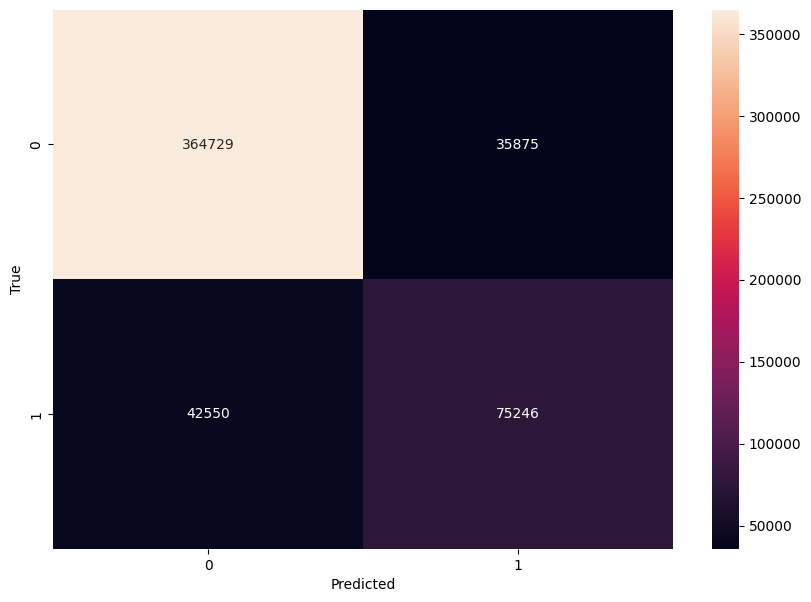

In [ ]:
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(best_epoch_targets, best_epoch_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

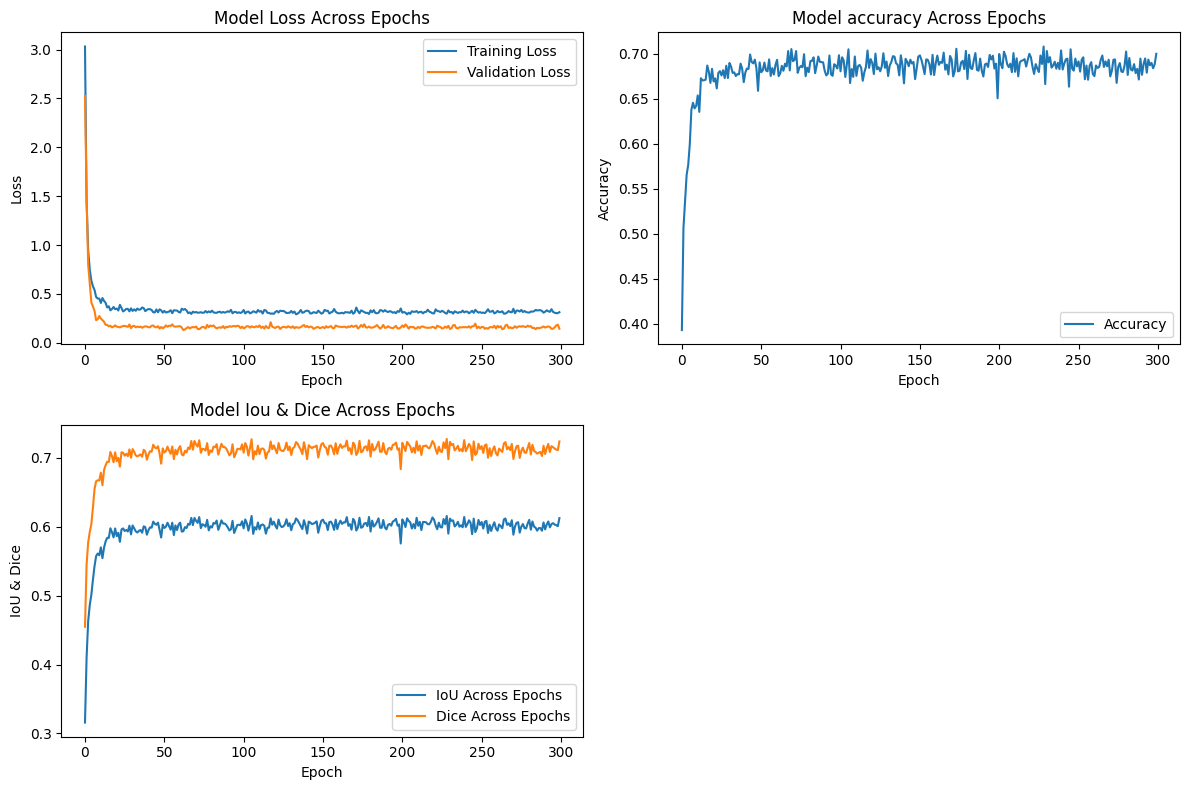

In [ ]:
plt.figure(figsize=(12, 8))

# Plotting Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plotting Dice
plt.subplot(2, 2, 2)
plt.plot(accuracy_list, label='Accuracy')
plt.title('Model accuracy Across Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(iou_list, label='IoU Across Epochs')
plt.plot(dice_list, label='Dice Across Epochs')
plt.title('Model Iou & Dice Across Epochs')
plt.ylabel('IoU & Dice')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_transformed = A.Compose([
    A.Resize(width=2000, height=2000),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])
test_dataset = CustomDataset("/content/drive/MyDrive/NAVER", "/content/drive/MyDrive/Tiên/test.txt", test_transformed)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)


# Test

Image ID: 0, Unique values in prediction: [ 0  1 17 43], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


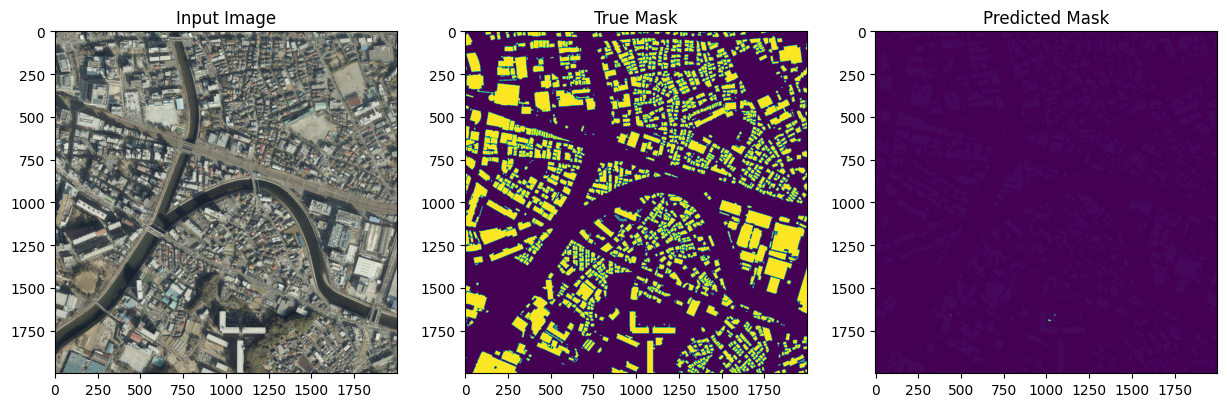

Image ID: 1, Unique values in prediction: [0 1], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


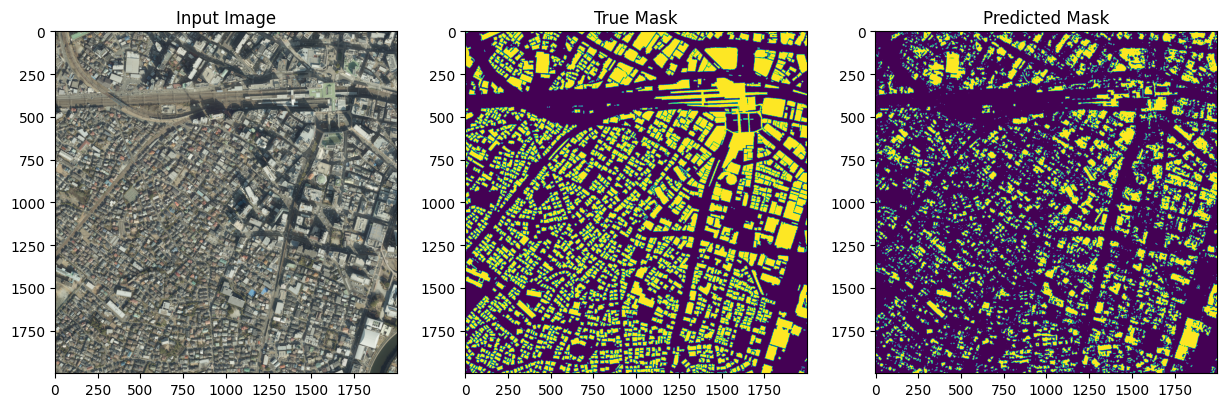

Image ID: 2, Unique values in prediction: [0 1], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


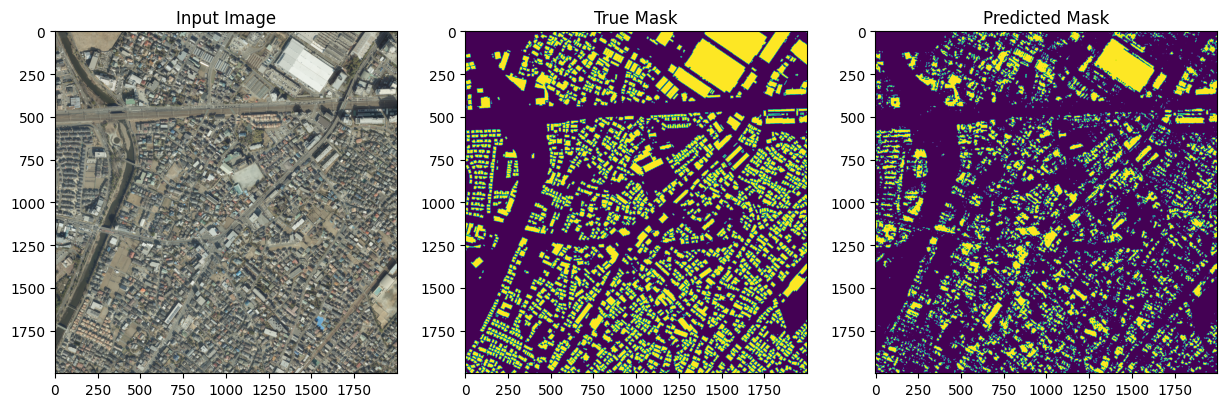

Image ID: 3, Unique values in prediction: [0 1], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


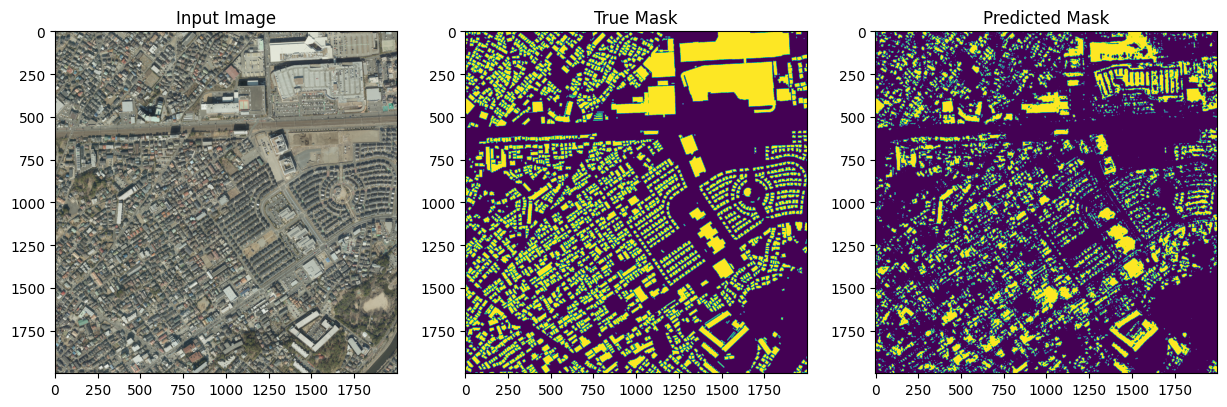

Image ID: 4, Unique values in prediction: [ 0  1 12], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


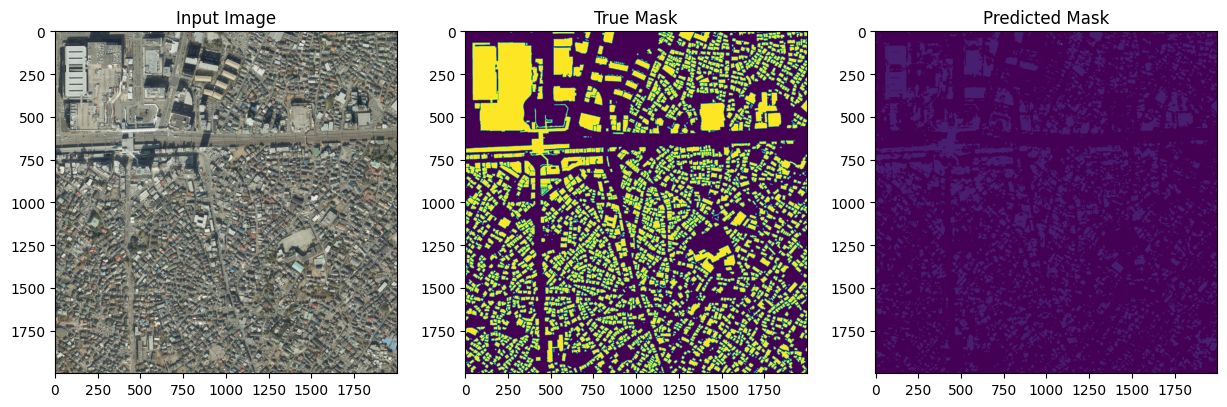

Image ID: 5, Unique values in prediction: [ 0  1 12 43], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


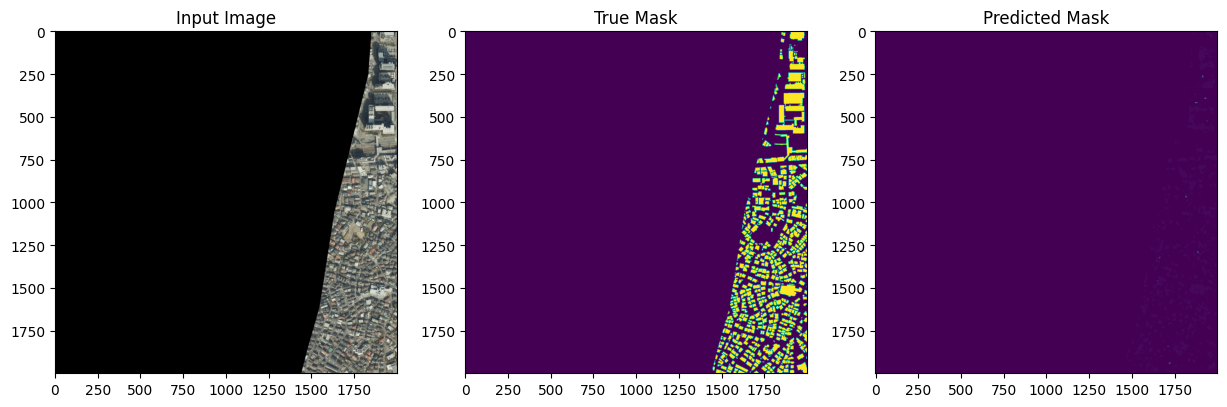

Image ID: 6, Unique values in prediction: [0], Unique values in ground truth: [0]
Shape of prediction: (2000, 2000)


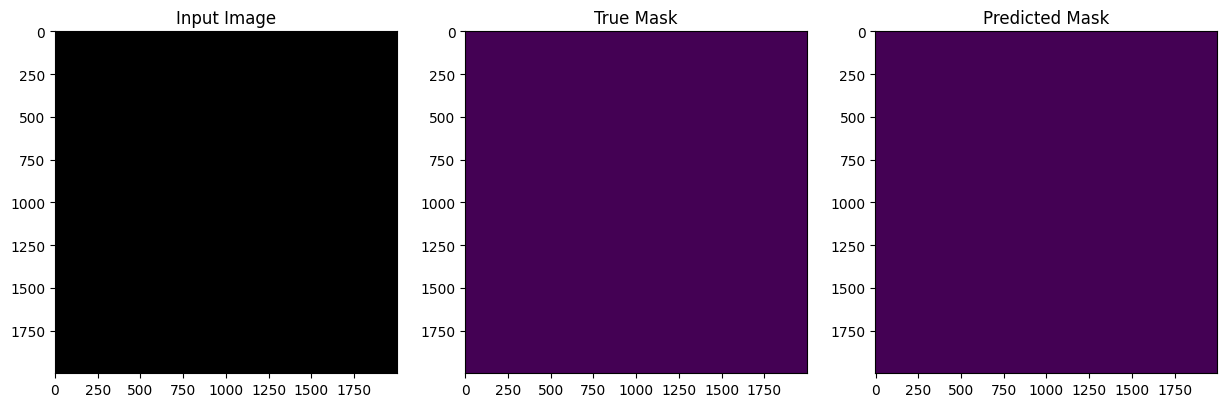

Image ID: 7, Unique values in prediction: [  0   1  82 125], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


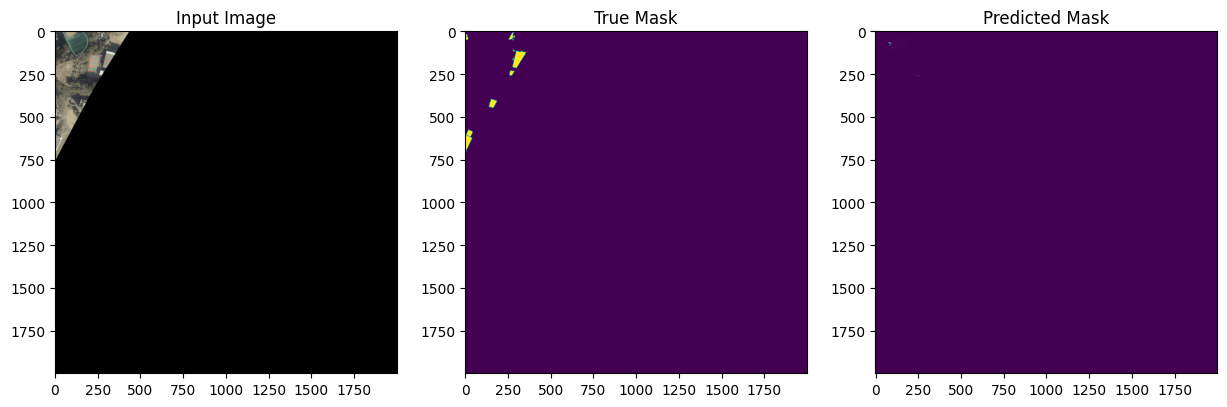

Image ID: 8, Unique values in prediction: [ 0  1 12], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


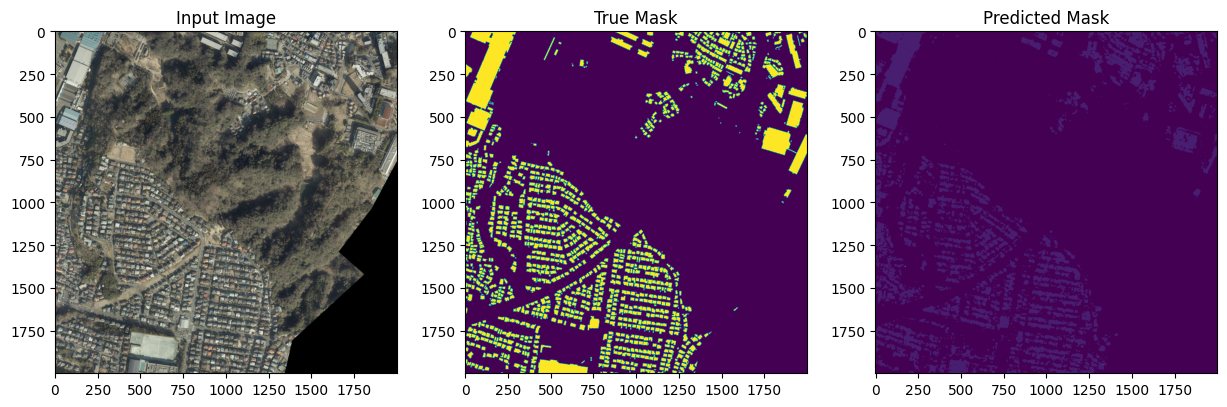

Image ID: 9, Unique values in prediction: [0 1], Unique values in ground truth: [0 1]
Shape of prediction: (2000, 2000)


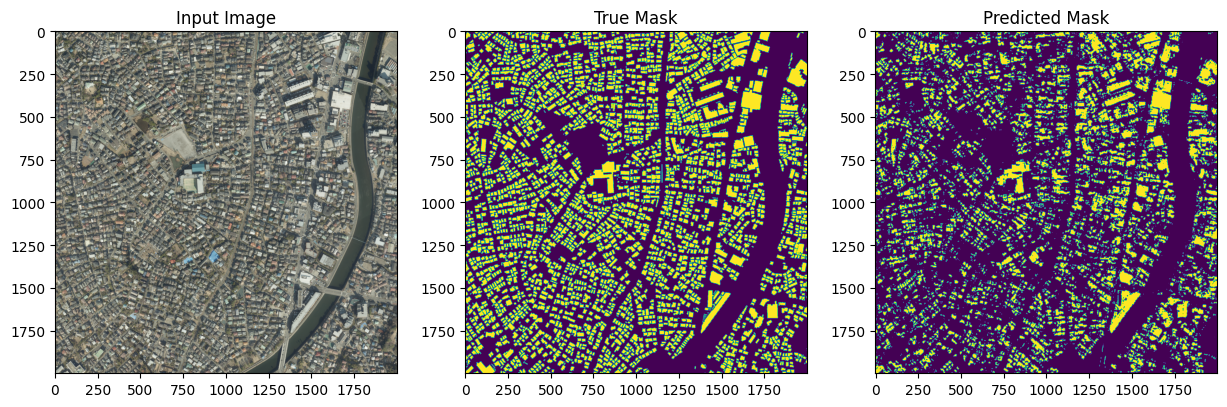

In [ ]:
import random
import numpy as np

with torch.no_grad():
    model.eval()
    for id in range(len(test_dataset)):
        x, y = test_dataset.__getitem__(id)
        y_predicted = F.interpolate(model(x.unsqueeze(0).to(device)).logits, size=y.shape, mode="bilinear").argmax(dim=1).squeeze().cpu().numpy()
        print(f"Image ID: {id}, Unique values in prediction: {np.unique(y_predicted)}, Unique values in ground truth: {np.unique(y)}")
        print(f"Shape of prediction: {y_predicted.shape}")

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots
        axs[0].imshow(unorm(x).cpu().permute(1, 2, 0))  # Display the input image
        axs[0].set_title('Input Image')
        axs[1].imshow(y)  # Display the ground truth mask
        axs[1].set_title('True Mask')
        axs[2].imshow(y_predicted)  # Display the predicted mask
        axs[2].set_title('Predicted Mask')
        plt.show()
